In [26]:
import pandas as pd
import os
import pickle as pk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
results_path = '/home/joud/code/relu_analysis/dynn/src/notebooks/msdnet/results'
cifar100_boosted_results_path = f'{results_path}/cifar100/dynamic_boosted_300.txt'
cifar100_msdnet_results_path = f'{results_path}/cifar100/dynamic_not_boosted.txt'
cifar10_boosted_results_path = f'{results_path}/cifar10/dynamic_boosted.txt'
cifar10_msdnet_results_path = f'{results_path}/cifar10/dynamic_not_boosted.txt'
cifar100_full_model_mac = 60307544
cifar10_full_model_mac = 47698994
# cifar100_boosted_results_path = f'{results_path}/cifar100/dynamic_flat_boosted.txt'
# cifar100_msdnet_results_path = f'{results_path}/cifar100/dynamic_flat_not_boosted.txt'

In [27]:
dataset = 'cifar100'
boo_name = 'BoostedNet'
w_name = 'L2W-DEN'
our_name = 'ConfEE'

if dataset == 'cifar10':
    model = 't2t_7'
    long_name = 't2t_vit_7'
    total_mudaa = 13.4
    end_acc = 94.5
    lambda_val_1 = 0.1
    lambda_val_2 = 0.9
    end_plot_acc = 0.85*end_acc
    line_acc = end_acc*0.9
    line_acc_label =r'$90\%$ of end accuracy'
    path = '/home/joud/code/relu_analysis/dynn/src/notebooks/cifar10_t2t_7'
    L=7
elif dataset == 'cifar100':
    model = 't2t_14'
    long_name = 't2t_vit_14'
    total_mudaa = 56
    end_acc = 88.4
    L=14
    lambda_val_1 = 0.01
    lambda_val_2 = 0.9
    end_plot_acc = 0.4*end_acc
    line_acc = end_acc*0.7
    line_acc_label =r'$70\%$ of end accuracy'
    path = '/home/joud/code/relu_analysis/dynn/src/notebooks/cifar100_t2t_14'

list_files = os.listdir(path)

list_dicts_ours = []
for file_name in list_files:

    if '.pk' in file_name and 'baseline' not in file_name and 'boosted' not in file_name and 'weighted' not in file_name:
        lambda_val = float(file_name.split('_')[-2])
        print(file_name)
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        dicts['lambda'] = lambda_val
        list_dicts_ours.append(dicts)
        print(lambda_val)
        if lambda_val == lambda_val_1:
            our_point_to_display = dicts
            print('got point 1')
        if lambda_val == lambda_val_2:
            our_point2_to_display = dicts
            print('got point 2')

our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

our_df = pd.DataFrame()
for metrics in list_dicts_ours:
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])
    metrics_we_care_about['ACC'] = metrics_we_care_about['test/gated_acc']

    metrics_we_care_about['ECE'] =metrics_we_care_about['test/gated_ece']

    df = pd.DataFrame(data=metrics_we_care_about)

    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)

with open('/home/joud/code/relu_analysis/dynn/src/notebooks/cifar100_t2t_14'+'/'+long_name+'_boosted_'+dataset+'_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)

with open('/home/joud/code/relu_analysis/dynn/src/notebooks/cifar100_t2t_14'+'/'+long_name+'_weighted_'+dataset+'_results.pk', 'rb') as file:
    list_dict_weighted = pk.load(file)

def replace_if_closer(points,closest_to_points, val, this_point):
    for i, point in enumerate(points):
        dif_now = np.abs(val-point)
        #print(dif_now)
        dif_prev = closest_to_points[i][1]
        if dif_now< dif_prev:
            closest_to_points[i] = (this_point, dif_now)
    return closest_to_points
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys_dict = {}
    C_keys_dict = {}
    for key in metrics.keys():
        if 'emp_alpha' in key:
            tokens = key.split('emp_alpha')
            alpha = tokens[1]
            prefix = tokens[0]

            cov_key = prefix+'emp_alpha'+alpha
            C_key = prefix+'C'+alpha
            if prefix in cov_keys_dict:
                cov_keys_dict[prefix].append(cov_key)
                C_keys_dict[prefix].append(C_key)
            else:
                cov_keys_dict[prefix] = [cov_key]
                C_keys_dict[prefix] = [C_key]
    return cov_keys_dict, C_keys_dict

def get_all_key_with(metrics, substring):
    keys_with_substring = []
    for key in metrics.keys():
        if substring in key:
            keys_with_substring.append(key)
    return keys_with_substring

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
            alpha_val = float(cov_key.split('_')[-1])
            emp_alpha = metrics_we_care_about['average'+cov_key]
            if emp_alpha< requested_alpha:
                if alpha_max < alpha_val:
                    alpha_max = alpha_val
                    #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
keys_ece = get_all_key_with(list_dicts_ours[-1], 'test/ece')
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys_dict, C_keys_dict = get_all_cov_C(list_dicts_ours[0])
type_of_conf = 'test/sets_general_'
cov_keys = cov_keys_dict[type_of_conf]
C_keys = C_keys_dict[type_of_conf]
cov_keys_baseline = cov_keys
C_keys_baseline = C_keys
requested_alpha = 0.05
def collect_baseline_data(list_dict_baseline, points):
    baseline_df = pd.DataFrame()
    closest_to_points = [(None, 100) for _ in points]
    for metrics in list_dict_baseline:
        metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])/total_mudaa
        metrics['average_ACC'] = np.mean(metrics['ACC'])
        ic = np.mean(metrics['EXPECTED_FLOPS'])

        closest_to_points = replace_if_closer(points,closest_to_points, ic, metrics)

        for cov_key in cov_keys_baseline:
            alpha = float(cov_key.split('alpha_')[-1])
            metrics['average'+cov_key] = np.mean(metrics[cov_key])
            metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
        for C_key in C_keys_baseline:
            metrics['average'+C_key] = np.mean(metrics[C_key])

        alpha_max = find_highest_cov(metrics, cov_keys_baseline, requested_alpha)

        if alpha_max >0 :
            C_key = type_of_conf+'C_'+str(alpha_max)
            metrics['C'] = metrics[C_key]
            metrics['emp_alpha'] = alpha_max
        df = pd.DataFrame(data=metrics)
        baseline_df = pd.concat([df, baseline_df],axis=0, ignore_index=True)
    return baseline_df, [tuple_points[0] for tuple_points in closest_to_points]

our_point_ic  = np.mean(our_point_to_display['test/total_cost'])
our_point_acc  = np.mean(our_point_to_display['test/gated_acc'])
boosted_df, boosted_points = collect_baseline_data(list_dict_boosted, [our_point_ic, our_point_ic])
boosted_df['method'] = boo_name
weighted_df, weighted_points = collect_baseline_data(list_dict_weighted, [our_point_ic, our_point_ic])
weighted_df['method'] = w_name
boosted_point_ic  = np.mean(boosted_points[0]['average_IC'])
boosted_point_acc  = np.mean(boosted_points[0]['ACC'])

weighted_point_ic  = np.mean(weighted_points[0]['average_IC'])
weighted_point_acc  = np.mean(weighted_points[0]['ACC'])

filtered_boosted_df = boosted_df[boosted_df['average_ACC'].between(end_plot_acc, end_acc)]

filtered_weighted_df = weighted_df[weighted_df['average_ACC'].between(end_plot_acc, end_acc)]

09-22-2023_cifar100_t2t_vit_14_2.0_results.pk
2.0
09-22-2023_cifar100_t2t_vit_14_0.9_results.pk
0.9
got point 2
09-22-2023_cifar100_t2t_vit_14_5.0_results.pk
5.0
09-21-2023_cifar100_t2t_vit_14_0.5_results.pk
0.5
09-21-2023_cifar100_0.01_results.pk
0.01
got point 1
09-21-2023_cifar100_t2t_vit_14_2.8_results.pk
2.8
09-21-2023_cifar100_t2t_vit_14_0.8_results.pk
0.8
09-21-2023_cifar100_t2t_vit_14_1.5_results.pk
1.5
09-21-2023_cifar100_t2t_vit_14_0.6_results.pk
0.6
09-22-2023_cifar100_t2t_vit_14_1.0_results.pk
1.0
09-21-2023_cifar100_t2t_vit_14_3.0_results.pk
3.0
09-21-2023_cifar100_t2t_vit_14_0.7_results.pk
0.7


/tmp/ipykernel_44039/575958609.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  boosted_df['method'] = boo_name
/tmp/ipykernel_44039/575958609.py:172: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_df['method'] = w_name


In [28]:
filtered_boosted_df['acc'] = filtered_boosted_df['average_ACC']
filtered_boosted_df['MAC'] = filtered_boosted_df['average_IC'] * total_mudaa / 10

/tmp/ipykernel_44039/490214590.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_boosted_df['acc'] = filtered_boosted_df['average_ACC']
/tmp/ipykernel_44039/490214590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_boosted_df['acc'] = filtered_boosted_df['average_ACC']
/tmp/ipykernel_44039/490214590.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

In [29]:
filtered_weighted_df['acc'] = filtered_weighted_df['average_ACC']
filtered_weighted_df['MAC'] = filtered_weighted_df['average_IC'] * total_mudaa/ 10

/tmp/ipykernel_44039/4151510737.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_weighted_df['acc'] = filtered_weighted_df['average_ACC']
/tmp/ipykernel_44039/4151510737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weighted_df['acc'] = filtered_weighted_df['average_ACC']
/tmp/ipykernel_44039/4151510737.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

In [30]:
filtered_boosted_df['method'] = 'T2T-ViT-14 (Boosted)'
filtered_weighted_df['method'] = 'T2T-ViT-14 (L2W)'

/tmp/ipykernel_44039/4063021598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_boosted_df['method'] = 'T2T-ViT-14 (Boosted)'
/tmp/ipykernel_44039/4063021598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weighted_df['method'] = 'T2T-ViT-14 (L2W)'


In [31]:
cifar_100_msdnet_boosted = pd.read_csv(cifar100_boosted_results_path)
cifar_100_msdnet = pd.read_csv(cifar100_msdnet_results_path)

cifar_100_msdnet_boosted['MAC'] = cifar_100_msdnet_boosted['MAC'] / 1e7
cifar_100_msdnet['MAC'] = cifar_100_msdnet['MAC'] / 1e7

cifar_10_msdnet_boosted = pd.read_csv(cifar10_boosted_results_path)
cifar_10_msdnet = pd.read_csv(cifar10_msdnet_results_path)
cifar_10_msdnet_boosted['MAC'] = cifar_10_msdnet_boosted['MAC'] / 1e7
cifar_10_msdnet['MAC'] = cifar_10_msdnet['MAC'] / 1e7
# print(boosted)
# print(our_df)
our_df['acc'] = our_df['average_ACC']
our_df['MAC'] = our_df['average_IC'] / 10
our_df['method'] = 'T2T-ViT-14 (JEI-DNN)'

# print(our_df.iloc[-1]['acc'])

/tmp/ipykernel_44039/2771445680.py:72: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  plot_1 = sns.lineplot(data=t2t_df, x="MAC", y="acc", hue="method", style="method",
/tmp/ipykernel_44039/2771445680.py:75: UserWarning: 
The markers list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  plot_2 = sns.lineplot(data=msdnet_df, x="MAC", y="acc", hue="method", style="method",


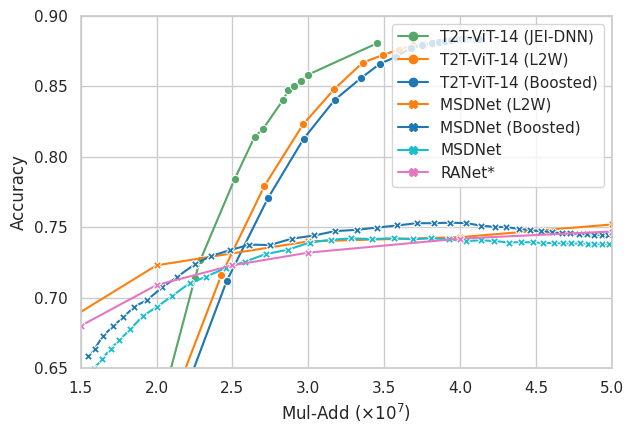

In [37]:
sns.set(font_scale=1.5)
sns.set_theme(style="whitegrid")
cifar_100_msdnet_boosted['method'] = "MSDNet (Boosted)"
cifar_100_msdnet['method'] = "MSDNet"
reported_msdnet_method = 'MSDNet*'
reported_resnet_method = 'ResNets*'
reported_boostnet_method = 'BoostedMSDNet*'
reported_sdn_method = 'Reported SDN'
reported_ran_method = 'RANet*'
reported_l2w_method = 'MSDNet (L2W)'
reported_msdnet_dict = [{'method': reported_msdnet_method, 'acc': 65, 'MAC': 1.5},
        {'method': reported_msdnet_method, 'acc': 69, 'MAC': 2},
        {'method': reported_msdnet_method, 'acc': 71.9, 'MAC': 2.6},
        {'method': reported_msdnet_method, 'acc': 73, 'MAC': 3},
        {'method': reported_msdnet_method, 'acc': 73.8, 'MAC': 3.3},
        {'method': reported_msdnet_method, 'acc': 74, 'MAC': 4},
        {'method': reported_msdnet_method, 'acc': 74.6, 'MAC': 5},
        # {'method': 'Rep MSDNet', 'acc': 74.9, 'MAC': 6},
        # {'method': 'Rep MSDNet', 'acc': 74.8, 'MAC': 6.5},
        # {'method': 'Rep MSDNet', 'acc': 74.7, 'MAC': 8},
        ]
reported_boosted_dict = [{'method': reported_boostnet_method, 'acc': 65.1, 'MAC': 1.5},
        {'method': reported_boostnet_method, 'acc': 69.1, 'MAC': 2},
        {'method': reported_boostnet_method, 'acc': 73, 'MAC': 2.6},
        {'method': reported_boostnet_method, 'acc': 74.4, 'MAC': 3},
        {'method': reported_boostnet_method, 'acc': 74.7, 'MAC': 3.3},
        {'method': reported_boostnet_method, 'acc': 75, 'MAC': 4},
        {'method': reported_boostnet_method, 'acc': 75.5, 'MAC': 5},
        # {'method': 'Rep MSDNet', 'acc': 74.9, 'MAC': 6},
        # {'method': 'Rep MSDNet', 'acc': 74.8, 'MAC': 6.5},
        # {'method': 'Rep MSDNet', 'acc': 74.7, 'MAC': 8},
        ]

reported_resnet_dict = [{'method': reported_resnet_method, 'acc': 65.8, 'MAC': 5.3},
        {'method': reported_resnet_method, 'acc': 68.6, 'MAC': 11},
        ]
reported_sdn_dict = [{'method': reported_sdn_method, 'acc': 66.2, 'MAC': 6},
        {'method': reported_sdn_method, 'acc': 68.2, 'MAC': 6.7},
        {'method': reported_sdn_method, 'acc': 70, 'MAC': 7.6},
        {'method': reported_sdn_method, 'acc': 71.3, 'MAC': 8.8},
        {'method': reported_sdn_method, 'acc': 71.5, 'MAC': 9.5},
        ]
reported_ranet_dict = [{'method': reported_ran_method, 'acc': 70.9, 'MAC': 2},
         {'method': reported_ran_method, 'acc': 68, 'MAC': 1.5},
        {'method': reported_ran_method, 'acc': 73.2, 'MAC': 3},
        {'method': reported_ran_method, 'acc': 72.3, 'MAC': 2.5},
        {'method': reported_ran_method, 'acc': 74.2, 'MAC': 4},
        {'method': reported_ran_method, 'acc': 74.7, 'MAC': 5},
        {'method': reported_ran_method, 'acc': 74.8, 'MAC': 6},
        ]
reported_l2w_dict = [{'method': reported_l2w_method, 'acc': 65, 'MAC': 0.9},
        {'method': reported_l2w_method, 'acc': 72.3, 'MAC': 2},
        {'method': reported_l2w_method, 'acc': 74, 'MAC': 3},
        {'method': reported_l2w_method, 'acc': 74.3, 'MAC': 4},
        {'method': reported_l2w_method, 'acc': 75.2, 'MAC': 5},
        {'method': reported_l2w_method, 'acc': 75.8, 'MAC': 6},
        ]
reported_msdnet = pd.DataFrame(reported_msdnet_dict)
reported_boosted = pd.DataFrame(reported_boosted_dict)
reported_resnet = pd.DataFrame(reported_resnet_dict)
reported_sdn = pd.DataFrame(reported_sdn_dict)
reported_ranet = pd.DataFrame(reported_ranet_dict)
reported_l2w = pd.DataFrame(reported_l2w_dict)
# line_extension = {"MAC": 5.6, "acc": our_df.iloc[-1]['acc'], "method": "confEE"}
# our_df.loc[len(our_df)] = line_extension
t2t_df = pd.concat([our_df, filtered_weighted_df, filtered_boosted_df],axis=0, ignore_index=True)
msdnet_df = pd.concat([reported_l2w, cifar_100_msdnet_boosted, cifar_100_msdnet, reported_ranet],axis=0, ignore_index=True)
# print(combined_df)
t2t_df['acc'] = t2t_df['acc'] / 100
msdnet_df['acc'] = msdnet_df['acc'] / 100
fig = plt.figure(figsize=(6.5,4.5))
plot_1 = sns.lineplot(data=t2t_df, x="MAC", y="acc", hue="method", style="method",
             markers='o', dashes=False, palette=['g', 'tab:orange', 'tab:blue'])
ax = fig.axes[0]
plot_2 = sns.lineplot(data=msdnet_df, x="MAC", y="acc", hue="method", style="method",
                      palette=['tab:orange', 'tab:blue', 'tab:cyan', 'tab:pink'], markers='X', dashes=False)
# leg_2 = ax.legend(plot_2.legend_.legend_handles, ['a', 'b', 'c', 'd'])
# plt.axhline(y=line_acc, color='k',linestyle='--', label=line_acc_label)
# plt.plot(boosted['MAC'], boosted['acc'], color='r', label='boosted')
# plt.plot(msdnet['MAC'], msdnet['acc'], color='b', label='msdnet')
x_label = r'Mul-Add ($\times 10^7$)'

# ax.add_artist(leg_1)
# ax.add_artist(leg_2)

plt.xlabel(x_label)
plt.ylabel("Accuracy")
# plt.legend(loc='upper right')
# x_string = r'Mul-Add ('+str(total_mudaa)+'$ \\times 10^6$)'
# plt.xlabel(x_string)
# plt.ylabel('Accuracy')
plt.ylim([0.65, 0.9])
plt.xlim([1.5, 5])
plt.legend(loc='upper right')
plt.tight_layout()
# print(dataset)
plt.savefig('msdnet_'+dataset+'.pdf')

/tmp/ipykernel_13212/960875435.py:11: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=combined_df, x="MAC", y="acc", hue="method", style="method",


          MAC    acc         method  test/gated_acc  test/gated_ece  \
0    1.548998  91.50  BoostedMSDNet             NaN             NaN   
1    1.590774  92.16  BoostedMSDNet             NaN             NaN   
2    1.637270  92.62  BoostedMSDNet             NaN             NaN   
3    1.692557  92.87  BoostedMSDNet             NaN             NaN   
4    1.752842  93.07  BoostedMSDNet             NaN             NaN   
..        ...    ...            ...             ...             ...   
193       NaN    NaN            NaN       78.250000       18.599782   
194       NaN    NaN            NaN       78.428571       18.843793   
195       NaN    NaN            NaN       78.425000       18.715051   
196       NaN    NaN            NaN       78.655556       18.876936   
197       NaN    NaN            NaN       78.830000       18.924308   

     test/total_cost  test/acc_exit  average_IC  average_ACC        ACC  \
0                NaN            NaN         NaN          NaN        NaN 

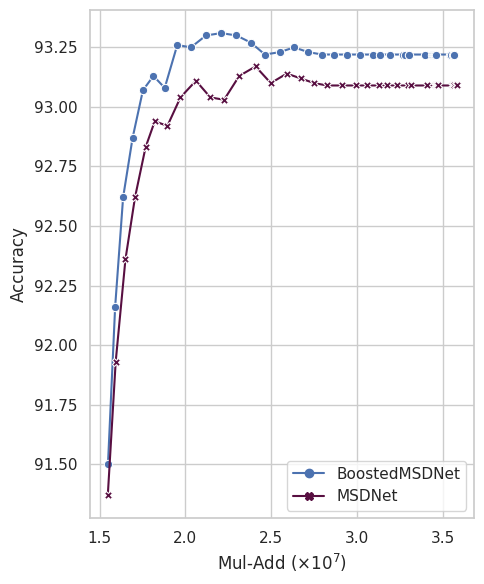

In [35]:
sns.set(font_scale=1.5)
sns.set_theme(style="whitegrid")
cifar_10_msdnet_boosted['method'] = "BoostedMSDNet"
cifar_10_msdnet['method'] = "MSDNet"
# line_extension = {"MAC": 5.6, "acc": our_df.iloc[-1]['acc'], "method": "confEE"}
# our_df.loc[len(our_df)] = line_extension
combined_df = pd.concat([cifar_10_msdnet_boosted, cifar_10_msdnet, our_df],axis=0, ignore_index=True)
print(combined_df)

plt.figure(figsize=(5,6))
sns.lineplot(data=combined_df, x="MAC", y="acc", hue="method", style="method",
             markers=True, dashes=False, palette=['b', sns.xkcd_rgb['plum'], 'g', sns.xkcd_rgb['apricot']])
# plt.axhline(y=line_acc, color='k',linestyle='--', label=line_acc_label)
# plt.plot(boosted['MAC'], boosted['acc'], color='r', label='boosted')
# plt.plot(msdnet['MAC'], msdnet['acc'], color='b', label='msdnet')
x_label = r'Mul-Add ($\times 10^7$)'

plt.xlabel(x_label)
plt.ylabel("Accuracy")
plt.legend()
# x_string = r'Mul-Add ('+str(total_mudaa)+'$ \\times 10^6$)'
# plt.xlabel(x_string)
# plt.ylabel('Accuracy')
plt.tight_layout()
print(dataset)
plt.savefig('msdnet_'+dataset+'.pdf')

          MAC    acc         method  test/gated_acc  test/gated_ece  \
0    1.550512  65.84  BoostedMSDNet             NaN             NaN   
1    1.593338  66.39  BoostedMSDNet             NaN             NaN   
2    1.646003  67.26  BoostedMSDNet             NaN             NaN   
3    1.711672  67.97  BoostedMSDNet             NaN             NaN   
4    1.781369  68.62  BoostedMSDNet             NaN             NaN   
..        ...    ...            ...             ...             ...   
212  2.000000  70.90         RANet*             NaN             NaN   
213  3.000000  73.20         RANet*             NaN             NaN   
214  2.500000  72.30         RANet*             NaN             NaN   
215  4.000000  74.20         RANet*             NaN             NaN   
216  5.000000  74.70         RANet*             NaN             NaN   

     test/total_cost  test/acc_exit  average_IC  average_ACC  ACC  ECE  
0                NaN            NaN         NaN          NaN  NaN  NaN  
1

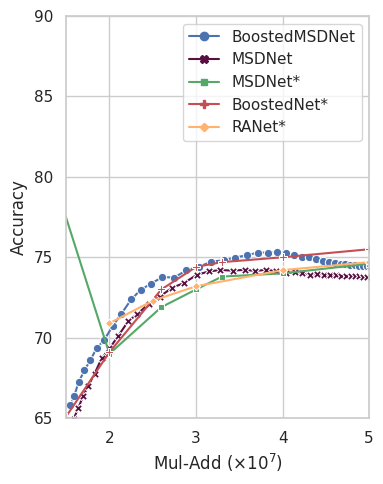

In [36]:
sns.set(font_scale=1.5)
sns.set_theme(style="whitegrid")
cifar_10_msdnet_boosted['method'] = "BoostedNet"
cifar_10_msdnet['method'] = "MSDNet"
reported_msdnet_method = 'MSDNet*'
reported_resnet_method = 'ResNets*'
reported_boostnet_method = 'BoostedNet*'
reported_sdn_method = 'Reported SDN'
reported_ran_method = 'RANet*'
reported_msdnet_dict = [{'method': reported_msdnet_method, 'acc': 91, 'MAC': 0.7},
        {'method': reported_msdnet_method, 'acc': 69, 'MAC': 2},
        {'method': reported_msdnet_method, 'acc': 71.9, 'MAC': 2.6},
        {'method': reported_msdnet_method, 'acc': 73, 'MAC': 3},
        {'method': reported_msdnet_method, 'acc': 73.8, 'MAC': 3.3},
        {'method': reported_msdnet_method, 'acc': 74, 'MAC': 4},
        {'method': reported_msdnet_method, 'acc': 74.6, 'MAC': 5},
        # {'method': 'Rep MSDNet', 'acc': 74.9, 'MAC': 6},
        # {'method': 'Rep MSDNet', 'acc': 74.8, 'MAC': 6.5},
        # {'method': 'Rep MSDNet', 'acc': 74.7, 'MAC': 8},
        ]
reported_boosted_dict = [{'method': reported_boostnet_method, 'acc': 65.1, 'MAC': 1.5},
        {'method': reported_boostnet_method, 'acc': 69.1, 'MAC': 2},
        {'method': reported_boostnet_method, 'acc': 73, 'MAC': 2.6},
        {'method': reported_boostnet_method, 'acc': 74.4, 'MAC': 3},
        {'method': reported_boostnet_method, 'acc': 74.7, 'MAC': 3.3},
        {'method': reported_boostnet_method, 'acc': 75, 'MAC': 4},
        {'method': reported_boostnet_method, 'acc': 75.5, 'MAC': 5},
        # {'method': 'Rep MSDNet', 'acc': 74.9, 'MAC': 6},
        # {'method': 'Rep MSDNet', 'acc': 74.8, 'MAC': 6.5},
        # {'method': 'Rep MSDNet', 'acc': 74.7, 'MAC': 8},
        ]

reported_resnet_dict = [{'method': reported_resnet_method, 'acc': 65.8, 'MAC': 5.3},
        {'method': reported_resnet_method, 'acc': 68.6, 'MAC': 11},
        ]
reported_sdn_dict = [{'method': reported_sdn_method, 'acc': 66.2, 'MAC': 6},
        {'method': reported_sdn_method, 'acc': 68.2, 'MAC': 6.7},
        {'method': reported_sdn_method, 'acc': 70, 'MAC': 7.6},
        {'method': reported_sdn_method, 'acc': 71.3, 'MAC': 8.8},
        {'method': reported_sdn_method, 'acc': 71.5, 'MAC': 9.5},
        ]
reported_ranet_dict = [{'method': reported_ran_method, 'acc': 70.9, 'MAC': 2},
        {'method': reported_ran_method, 'acc': 73.2, 'MAC': 3},
        {'method': reported_ran_method, 'acc': 72.3, 'MAC': 2.5},
        {'method': reported_ran_method, 'acc': 74.2, 'MAC': 4},
        {'method': reported_ran_method, 'acc': 74.7, 'MAC': 5},
        ]
reported_msdnet = pd.DataFrame(reported_msdnet_dict)
reported_boosted = pd.DataFrame(reported_boosted_dict)
reported_resnet = pd.DataFrame(reported_resnet_dict)
reported_sdn = pd.DataFrame(reported_sdn_dict)
reported_ranet = pd.DataFrame(reported_ranet_dict)
# line_extension = {"MAC": 5.6, "acc": our_df.iloc[-1]['acc'], "method": "confEE"}
# our_df.loc[len(our_df)] = line_extension
combined_df = pd.concat([cifar_100_msdnet_boosted, cifar_100_msdnet, our_df, reported_msdnet, reported_boosted, reported_ranet],axis=0, ignore_index=True)
print(combined_df)

plt.figure(figsize=(4,5))
sns.lineplot(data=combined_df, x="MAC", y="acc", hue="method", style="method",
             markers=True, dashes=False, palette=['b', sns.xkcd_rgb['plum'], 'g', 'r', sns.xkcd_rgb['apricot']])
# plt.axhline(y=line_acc, color='k',linestyle='--', label=line_acc_label)
# plt.plot(boosted['MAC'], boosted['acc'], color='r', label='boosted')
# plt.plot(msdnet['MAC'], msdnet['acc'], color='b', label='msdnet')
x_label = r'Mul-Add ($\times 10^7$)'

plt.xlabel(x_label)
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
# x_string = r'Mul-Add ('+str(total_mudaa)+'$ \\times 10^6$)'
# plt.xlabel(x_string)
# plt.ylabel('Accuracy')
plt.ylim([65, 90])
plt.xlim([1.5, 5])
plt.tight_layout()
print(dataset)
plt.savefig('msdnet_'+dataset+'.pdf')